In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
from PINN import PINN
import european_call

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
def plot_surface(x, y, z, title=''):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d', elev=30, azim=130)
    surf = ax.plot_surface(x, y, z, cmap='viridis', edgecolor='none')
    fig.colorbar(surf, shrink=0.5, aspect=10)
    ax.set_xlabel('S')
    ax.set_ylabel('t')
    ax.set_zlabel('u')
    ax.set_title(title)
    plt.show()

def random_tensor_2d(size: int, range_x, range_y):
    return torch.stack((
        torch.rand(size) * (range_x[1] - range_x[0]) + range_x[0],
        torch.rand(size) * (range_y[1] - range_y[0]) + range_y[0]), dim=1
    ).requires_grad_(True)

In [4]:
K = 40
r = 0.05
sigma = 0.15
T = [0.0, 1.0]
S = [0, 160]
t_sample_size = 500
S_sample_size = 500

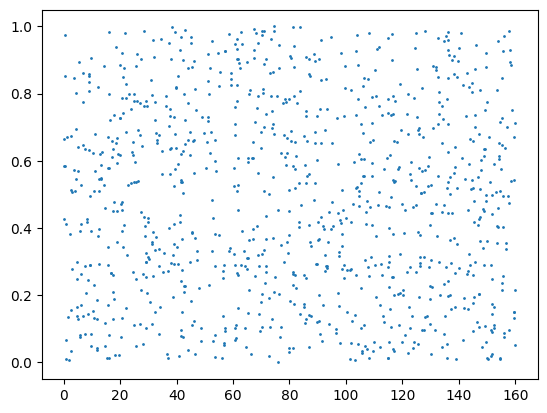

torch.Size([1000, 2])

In [7]:
t_samples = torch.linspace(T[0], T[1], t_sample_size)
S_samples = torch.linspace(S[0], S[1], S_sample_size)

# Boundary: C(0,t) = 0
boundary1 = torch.stack((torch.full((t_sample_size,), S[0]), t_samples), dim=1).requires_grad_(True).detach()
# Boundary: C(S->inf,t) = S-Ke^-r(T-t)
boundary2 = torch.stack((torch.full((t_sample_size,), S[1]), t_samples), dim=1).requires_grad_(True).detach()
# Boundary: C(S,T) = max(S-K, 0)
boundary3 = torch.stack((S_samples, torch.full((S_sample_size,), T[1])), dim=1).requires_grad_(True).detach()

# Mesh (S,t)
# mesh = torch.stack((torch.rand(S_sample_size**2), torch.rand(S_sample_size**2)*160), dim=1).detach()
x, y = torch.meshgrid(torch.linspace(S[0], S[1], 50), torch.linspace(T[0], T[1], 50))
mesh =  random_tensor_2d(S_sample_size*2, S, T).detach() # torch.stack((torch.rand(S_sample_size**2)*S[1], torch.rand(t_sample_size**2)*T[1]), dim=1).requires_grad_(True)
# mesh = torch.stack((x.flatten(), y.flatten()), dim=1).detach()

plt.scatter(mesh[:, 0], mesh[:, 1], s=1)
plt.show()
mesh.shape

In [55]:
pinn = PINN(2, 16, 1)
pinn.to(device)
mse_loss = nn.MSELoss()
optimizer = torch.optim.Adam(pinn.parameters(), lr=0.001)

# t_samples = torch.rand(t_sample_size)*T[1]
# S_samples = torch.rand(S_sample_size)*S[1] 
t_samples = torch.linspace(T[0], T[1], t_sample_size)
S_samples = torch.linspace(S[0], S[1], S_sample_size)

# Boundary: C(0,t) = 0
boundary1 = torch.stack((torch.full((t_sample_size,), S[0]), t_samples), dim=1).requires_grad_(True)
# Boundary: C(S->inf,t) = S-Ke^-r(T-t)
boundary2 = torch.stack((torch.full((t_sample_size,), S[1]), t_samples), dim=1).requires_grad_(True)
# Boundary: C(S,T) = max(S-K, 0)
boundary3 = torch.stack((S_samples, torch.full((S_sample_size,), T[1])), dim=1).requires_grad_(True)

# Mesh (S,t)
# mesh = torch.cartesian_prod(S_samples, t_samples).requires_grad_(True)
# torch.stack((torch.rand(S_sample_size**2)*S[1], torch.rand(t_sample_size**2)*T[1]), dim=1).requires_grad_(True)
random_mesh = random_tensor_2d(2500, S, T)
x, y = torch.meshgrid(torch.linspace(S[0], S[1], 50), torch.linspace(T[0], T[1], 50))
uniform_mesh = torch.stack((x.flatten(), y.flatten()), dim=1).requires_grad_(True)

def train(mesh):
    losses = []
    
    for i in tqdm(range(10000)):
        optimizer.zero_grad()
        
        # Hyperparameters for each loss term
        lambda_boundary1 = 1e-0
        lambda_boundary2 = 1e-0
        lambda_boundary3 = 1e-0
        lambda_pde = 1e-0
        lambda_data = 1e-0
        
        # t_samples1 = (torch.rand(t_sample_size)*T[1]).requires_grad_(True)
        # t_samples2 = (torch.rand(t_sample_size)*T[1]).requires_grad_(True)
        # S_samples = (torch.rand(S_sample_size)*S[1]).requires_grad_(True)
        
        # Boundary losses
        # boundary1 = torch.stack((torch.full((t_sample_size,), S[0]), t_samples1), dim=1).requires_grad_(True)
        u = pinn(boundary1)
        loss_boundary1 = lambda_boundary1 * mse_loss(u, boundary1)
        
        # boundary2 = torch.stack((torch.full((t_sample_size,), S[1]), t_samples1), dim=1).requires_grad_(True)
        u = pinn(boundary2)
        S_inf = S[1] - K * torch.exp(-r * (T[1] - t_samples))
        loss_boundary2 = lambda_boundary2 * mse_loss(u, S_inf)
        
        # boundary3 = torch.stack((S_samples, torch.full((S_sample_size,), T[1])), dim=1).requires_grad_(True)
        u = pinn(boundary3)
        loss_boundary3 = lambda_boundary3 * mse_loss(u, torch.fmax(S_samples-K, torch.tensor(0)))
        
        boundary_loss = loss_boundary1 + loss_boundary2 + loss_boundary3
        
        # PDE loss
        # mesh = random_tensor_2d(2500, S, T)
        u = pinn(mesh)
        du = torch.autograd.grad(u, mesh, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        dudt, duds = du[:, 0], du[:, 1]
        d2uds2 = torch.autograd.grad(duds, mesh, grad_outputs=torch.ones_like(duds), create_graph=True)[0][:, 1]
        
        S1 = mesh[:, 1]
        pde_loss = lambda_pde * mse_loss(r*u, dudt + 0.5*sigma**2*S1**2*d2uds2 + r*S1*duds)
    
        # data loss 
        u = pinn(mesh)
        analytical = torch.tensor(european_call.black_scholes_call(S_samples.detach(), K, r, T[1], sigma), dtype=torch.float).requires_grad_(True)
        data_loss = lambda_data * mse_loss(u, analytical)
    
        loss = pde_loss + boundary_loss + data_loss
        
        losses.append([loss_boundary1.item(), loss_boundary2.item(), loss_boundary3.item(), pde_loss.item(), data_loss.item()])
    
        loss.backward()
    
        optimizer.step()
        
    return pinn, losses
        
pinn, losses = train(uniform_mesh)

  0%|          | 0/10000 [00:00<?, ?it/s]

/var/folders/fc/1h8c1q2j0l546qfdym_l1xg00000gn/T/ipykernel_8138/1069135471.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  analytical = torch.tensor(european_call.black_scholes_call(S_samples.detach(), K, r, T[1], sigma), dtype=torch.float).requires_grad_(True)


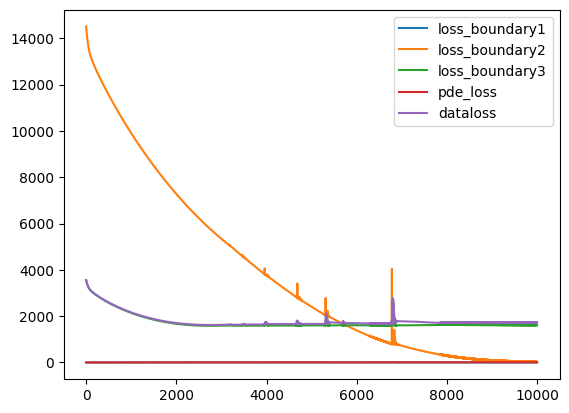

In [56]:
plt.plot(losses, label=['loss_boundary1', 'loss_boundary2', 'loss_boundary3', 'pde_loss', 'dataloss'])
# plt.title('Loss: ' + str(losses[-1]))
plt.legend()
plt.show()

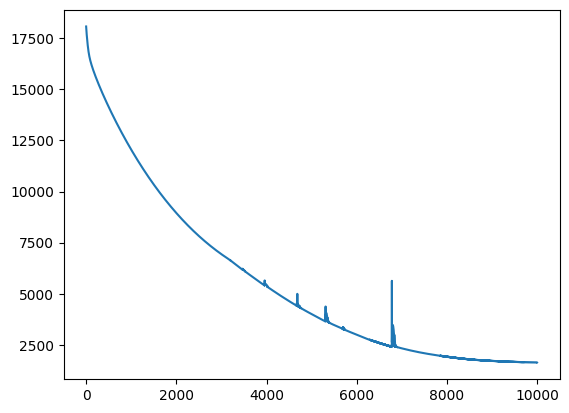

In [57]:
plt.plot([sum(item[:4]) for item in losses])
plt.show()

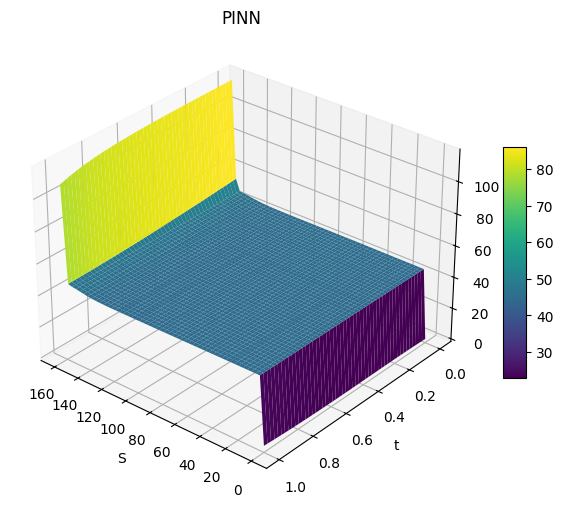

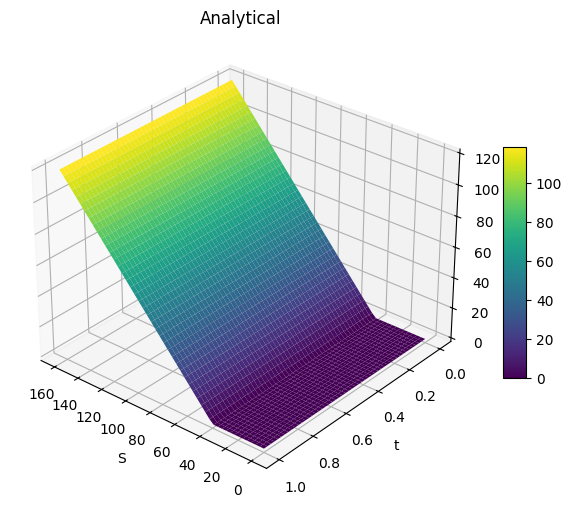

In [58]:
s_grid = np.linspace(S[0], S[1], 50)
t_grid = np.linspace(T[0], T[1], 50)
s_grid_mesh, t_grid_mesh = np.meshgrid(s_grid, t_grid)

c = pinn(uniform_mesh).detach().numpy().reshape(t_grid_mesh.shape).T

plot_surface(s_grid_mesh, t_grid_mesh, c, 'PINN')

bs = european_call.black_scholes_call(s_grid_mesh, K, r, T[1], sigma)
plot_surface(s_grid_mesh, t_grid_mesh, bs, 'Analytical')